## 3. Natural Language Processing
### 1. Preprocessing the documents for analysis
#### 1. Tokenize
* First we split the lyrics in two datasets, one for training and one for testing.
* For now we will work with the training set. We use gensims simple_preprocess function, to convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.

In [ ]:
import gensim
from sklearn.model_selection import train_test_split
import pandas as pd
from gensim.utils import simple_preprocess

lyrics = pd.read_csv('../dataset/Lyrics_en.csv', index_col=['Band'])
genres = pd.read_csv('../dataset/artists_final_ohe.csv', index_col=['Band'])
df = pd.merge(lyrics, genres, on=['Band'])
train, test = train_test_split(df, test_size=0.2)
train.to_csv('../dataset/Lyrics_en_artists_clean_train.csv')
test.to_csv('../dataset/Lyrics_en_artists_clean_test.csv')
del train
del test

df = pd.read_csv('../dataset/Lyrics_en_artists_clean_train.csv')
for index, row in df.iterrows():
    lyric = row[1]
    newLyric = gensim.utils.simple_preprocess(str(lyric), deacc=True)
    df.at[index, 'Lyrics'] = newLyric
df  

#### 2. Create bigrams and trigrams models
Use gensim Phraser to detect phrases, a phrase is a token formed by two (bigram) or more words. 

For example New and York may appear together very often, this process will detect them and join them as a single token New_York.

In [ ]:
from gensim.models.phrases import Phrases, Phraser

lyrics = list()
for i in range(0, df.shape[0]):
    lyric = df.iloc[i][1]
    lyrics.append(lyric)
    
bi_prhases = Phrases(lyrics, min_count=5, threshold=40)
tri_prhases = Phrases(bi_prhases[lyrics], threshold=40)  

bigram = Phraser(bi_prhases)
trigram = Phraser(tri_prhases)


#### 3. Remove stop words
There are words that have no meaning to our dataset. We use nltk stop words, add a couple of words (s and chorus) and then remove them from our dataset. 

In [6]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['s', 'chorus'])

new_lyrics = list()
for lyric in lyrics:
    new_lyric = list()
    for word in lyric:
        if(word not in stop_words):
            new_lyric.append(word)
    new_lyrics.append(new_lyric)
    
#print(lyrics[0])
#print(new_lyrics[0])
lyrics = new_lyrics
del new_lyrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jescobedo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 4. Lemmatize words
The are words that have no meaning, removed in previous step, but there are words with the same meaning as others (e.g. am, are, is = be). This time we use spacy to transform these words, only keeping nouns, adjetives, verbs and adverbs. 

In [7]:
bigram_lyrics = list()
for lyric in lyrics:
    bigram_lyrics.append(bigram[lyric])
lyrics = bigram_lyrics
del bigram_lyrics

In [8]:
del lemma_lyricsimport spacy
import en_core_web_sm

# python -m spacy download en
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
lemma_lyrics = list()
for lyric in lyrics:
    doc = nlp(" ".join(lyric)) 
    lemma_lyric = list()
    for token in doc:
        if(token.pos_ in allowed_postags):
            lemma_lyric.append(token.lemma_)
    lemma_lyrics.append(lemma_lyric)


print(lemma_lyrics[:1])
lyrics = lemma_lyrics

del lemma_lyrics

[['have', 'give', 'life', 'decadent', 'goal', 'bless', 'look', 'eye', 'repent', 'mass', 'night', 'sex', 'sinister', 'prize', 'beg', 'get', 'knee', 'pray', 'well', 'all', 'cast', 'first', 'stone', 'pride', 'lust', 'whore', 'night', 'drown', 'pleasure', 'inhale', 'love', 'bring', 'hatred', 'lie', 'await', 'indulgence', 'find', 'home', 'bear', 'blasphemer', 'die', 'cry', 'soul', 'damn', 'sky', 'communion', 'longer', 'suffice', 'flame', 'rise', 'demise', 'confession', 'lie']]


In [2]:
import pickle

#SAVE LYRICS to disk
with open('../dataset/lemma_lyrics_train', 'wb') as fp:
    pickle.dump(lyrics, fp)

NameError: name 'lemma_lyrics' is not defined

### Expand

In [ ]:
if(lyrics.size == df.shape[0]):
    print("Equal size")
    for index, lyric in lyrics:
        df.at[index, 'Lyrics'] = lyric
del lyrics
df

In [ ]:
genres = df.groupby(['Band']).sum().reset_index(drop=True).sum()
print(genres.describe())
genres.sort_values().plot()

In [ ]:
import random

big_genres = set()
for index,genre_sum in genres.iteritems():
    if(genre_sum > 50000):
        big_genres.add(index)

new_list = list()
for index,row in df.iterrows():
    expand = True
    for big_genre in big_genres:
        if(df[big_genre].iloc[index] == 1):
            expand = False
    if(expand):
        newRow = row.to_dict()
        ly = newRow['Lyrics'].split('\r\r\n\r\r\n')
        random.shuffle(ly, random.random)
        newLy = ''
        for paragraph in ly:
            newLy += paragraph + "\r\r\n\r\r\n"
        newRow['Lyrics'] = newLy
        new_list.append(newRow)
new_df = pd.DataFrame(new_list, columns=df.columns)
df = df.append(new_df)

Most common words

In [10]:
from collections import Counter

words = list()
for lyric in lyrics:
    for word in lyric:
        words.append(word)

word_freq = Counter(words)

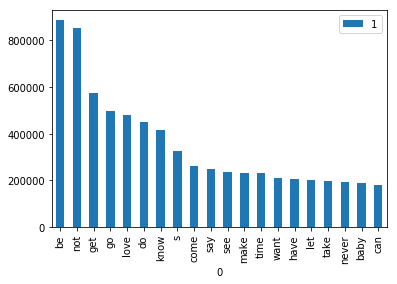

In [11]:
import pandas as pd
%matplotlib inline

df = pd.DataFrame.from_dict(word_freq.most_common(20))
df.plot(x=0, kind ='bar')

### 2. Words representation
#### 1. BOW and Tf-idf

* Using gensim's corpora we create a dictionary. A dictionary is the mapping of each word to an id.
* With this dictionary we create a bag of words **(BOW)** for each document, which is a list of tuples, with information of each token id (from the dictionary) and the number of times it appears in each document.
* Finally with the **BOWs** we create a term frequency - inverse document frequency model **(Tf-Idf)**, this model transforms each word frequency to its importance score in every document. The bigger the number, the more common.

In [4]:
import gensim.corpora as corpora
from gensim.models import TfidfModel

id2word = corpora.Dictionary(lyrics)
id2word.save("../dataset/lemma_lyrics_train_dict")

bow_corpus = list()

for lyric in lyrics:
    bow_corpus.append(id2word.doc2bow(lyric))

tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]
print(bow_corpus[0])
print(tfidf_corpus[0])

C:\Users\juanp\Anaconda3\envs\mlnd\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[(0, 2), (1, 1), (2, 1), (3, 13), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 3), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 45), (23, 1), (24, 3), (25, 3), (26, 1), (27, 5), (28, 1), (29, 6), (30, 1), (31, 1), (32, 1), (33, 4), (34, 3), (35, 1), (36, 1), (37, 1), (38, 4), (39, 1), (40, 2), (41, 1), (42, 2), (43, 2), (44, 6), (45, 1), (46, 1), (47, 2), (48, 7), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 3), (56, 3), (57, 1), (58, 5), (59, 2), (60, 2), (61, 3), (62, 1), (63, 1), (64, 1), (65, 3), (66, 3), (67, 2), (68, 1), (69, 1), (70, 1), (71, 2), (72, 3), (73, 2), (74, 3), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1)]
[(0, 0.05693230226707338), (1, 0.027704914478609205), (2, 0.04549673720943144), (3, 0.0289448229988323), (4, 0.015806998693867935), (5, 0.024025594355196165), (6, 0.023098009819700793), (7, 0.025811526273479265), (8, 0.010569261638354028), (9, 0.006612118130594775), (10, 0.0244344778227

#### 2. Word2Vec
* Word2Vec transforms a collection of documents and produces a vector space of each word.
* These vector are close to the vectors that are common to them.
* Word2Vec is a neural network of two dimmensions
* Here we use the continuos bag of word (CBOW) algorithm, that tries to predict a word based on its context. This is useful since skip-gram instead tries to predict the context, making it slower but more accurate on infrequent words. In our case, musicians have a small vocabulary.

In [199]:
from gensim.models.word2vec import Word2Vec

word2vec = Word2Vec(lyrics, workers=4, iter=3)
word_vectors = word2vec.wv
word2vec.save("../dataset/word2vec")

Now lets see the most similar words

In [14]:
word_vectors.similar_by_word("love")

[('loving', 0.7502729296684265),
 ('baby', 0.6895380020141602),
 ('true', 0.6719269752502441),
 ('know', 0.666519284248352),
 ('darling', 0.6553927659988403),
 ('unconditional', 0.6393495798110962),
 ('want', 0.6328312754631042),
 ('heart', 0.6235368251800537),
 ('darlin', 0.6204294562339783),
 ('give', 0.6028942465782166)]

In [15]:
word_vectors.similar_by_word("hate")

[('jealousy', 0.5478307604789734),
 ('envy', 0.5122020840644836),
 ('suffer', 0.5009539723396301),
 ('relate', 0.4845621585845947),
 ('hatred', 0.4722989797592163),
 ('hater', 0.47106990218162537),
 ('anger', 0.4707857072353363),
 ('tolerate', 0.4615577161312103),
 ('debate', 0.4562164843082428),
 ('worst_enemy', 0.45264697074890137)]

In [16]:
word_vectors.similar_by_word("god")

[('holy', 0.6329371929168701),
 ('bless', 0.6200424432754517),
 ('almighty', 0.6178418397903442),
 ('lord', 0.6115849018096924),
 ('pray', 0.6114975810050964),
 ('blessed', 0.5861982107162476),
 ('grace', 0.581980288028717),
 ('savior', 0.5815690755844116),
 ('forgif', 0.5763567686080933),
 ('saviour', 0.5717598795890808)]

In [17]:
word_vectors.similar_by_word("dog")

[('bark', 0.721328616142273),
 ('cat', 0.6756749153137207),
 ('leash', 0.5832235813140869),
 ('woof', 0.5778262615203857),
 ('buying_chihuahua', 0.543731689453125),
 ('waggin', 0.5247211456298828),
 ('hog', 0.523919939994812),
 ('wolf', 0.5199141502380371),
 ('doggy', 0.5101379156112671),
 ('kennel', 0.48979413509368896)]

### 7. Doc2Vec
* This model adds an extra description to the Word2Vec model, this model also adds a representation related to the document, not only the words.

In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_lyrics = [TaggedDocument(lyric, [i]) for i, lyric in enumerate(lyrics)]

doc2vec = Doc2Vec(tagged_lyrics, workers=4, epochs=3)
doc_vectors = doc2vec.docvecs

doc2vec.save("../dataset/doc2vec")

Lets see the most similar documents to the document

In [198]:
new_vector = doc2vec.infer_vector(['never', 'think', 'would', 'fall', 'hear', 'love', 'call', 'be', 'get', 'sentimental', 'thing'])
sims = doc_vectors.most_similar([new_vector], topn=5)
for sim in sims:
    print(lyrics[sim[0]], sim[1], sim[0])

['never', 'think', 'would', 'fall', 'hear', 'love', 'call', 'be', 'get', 'sentimental', 'thing', 'say', 'thrill', 'be', 'get', 'sentimental', 'thought', 'happy', 'could', 'live', 'love', 'must', 'admit', 'love', 'be', 'think', 'will', 'not', 'kind', 'make', 'mind', 'will', 'sweet', 'gentle', 'gentle', 'be', 'sentimental'] 0.6838473081588745 298879
['want', 'need', 'know', 'way', 'up', 'turnaround', 'know', 'feel', 'somehow', 'seem', 'find', 'mind', 'sunshine', 'horizon', 'know', 'feel', 'call', 'restore', 'know', 'feeling', 'somehow', 'seem', 'find', 'mind', 'rise', 'fall', 'call', 'look', 'eye', 'rise', 'fall', 'call', 'look', 'eye', 'see', 'smile', 'know', 'rise', 'fall', 'tonight', 'fine', 'line', 'light', 'shin', 'good', 'feeling', 'need', 'share', 'feeling', 'somehow', 'seem', 'find', 'mind', 'rise', 'fall', 'call', 'look', 'eye', 'rise', 'fall', 'call', 'look', 'eye', 'see', 'smile', 'know', 'rise', 'fall', 'tonight'] 0.6711493730545044 201502
['pretty', 'eye', 'pretty', 'eye', '

In [179]:
new_vector = doc2vec.infer_vector("hate".split())
sims = doc_vectors.most_similar([new_vector], topn=5)
for sim in sims:
    print(lyrics[sim[0]], sim[1])

['cover', 'waterfront', 'be', 'watch', 'sea', 'love', 'come', 'back', 'cover', 'waterfront', 'search', 'love', 'be', 'cover', 'patiently', 'wait', 'hop', 'longing', 'yearn', 'forget', 'remember', 'return', 'cover', 'waterfront', 'be', 'watch', 'sea', 'love', 'must', 'come', 'back'] 0.8228856921195984
['chestnuts_roast', 'open', 'fire', 'jack_frost', 'nip', 'nose_yuletide', 'carol', 'sing', 'choir', 'folk', 'dress', 'eskimos_everybody', 'knows_turkey', 'mistletoe', 'help', 'make', 'season', 'bright', 'tiny_tot', 'eye', 'aglow', 'find', 'hard', 'sleep', 'tonight', 'know', 'santa', 'way', 'loaded_lot', 'toy', 'goody', 'sleigh', 'mother', 'child', 'go', 'spy', 'see', 'reindeer', 'really', 'know', 'fly', 'be', 'offer', 'simple_phrase', 'kid', 'say', 'many', 'time', 'many', 'way', 'merry_christma', 'know', 'santa', 'way', 'toy', 'goody', 'sleigh', 'mother', 'child', 'go', 'spy', 'see', 'reindeer', 'really', 'know', 'fly', 'be', 'offer', 'simple_phrase', 'kid', 'say', 'many', 'time', 'many', 

In [180]:
new_vector = doc2vec.infer_vector("god".split())
sims = doc_vectors.most_similar([new_vector], topn=5)
for sim in sims:
    print(lyrics[sim[0]], sim[1])

['chestnuts_roast', 'open', 'fire', 'jack_frost', 'nip', 'nose_yule', 'tide_carol', 'sing', 'choir', 'folk', 'dress', 'eskimos_everybody', 'knows_turkey', 'mistletoe', 'help', 'make', 'season', 'bright', 'tiny_tot', 'eye', 'aglow', 'find', 'hard', 'sleep', 'tonight', 'know', 'santa', 'way', 'loaded_lot', 'toy', 'goody', 'sleigh', 'mother', 'child', 'go', 'spy', 'see', 'reindeer', 'really', 'know', 'fly', 'be', 'offer', 'simple_phrase', 'kid', 'say', 'many', 'time', 'many', 'way', 'merry_christma'] 0.8302822709083557
['have', 'get', 'know', 'really'] 0.8291538953781128
['hate', 'see', 'evening', 'sun', 'go', 'hate', 'see', 'evening', 'sun', 'go', 'baby', 'go', 'leave', 'town', 'feelin', 'tomorrow', 'feel', 'today', 'be', 'feelin', 'tomorrow', 'feel', 'today', 'ill', 'pack', 'truck', 'make', 'give', 'way', 'woman', 'diamond_r', 'pull', 'man', 'around', 'be', 'not', 'man', 'love', 'would', 'go', 'nowhere', 'nowhere', 'get', 'blue', 'blue', 'man', 'get', 'heart', 'rock', 'cast', 'sea', 'el

In [182]:
new_vector = doc2vec.infer_vector("dog".split())
sims = doc_vectors.most_similar([new_vector], topn=5)
for sim in sims:
    print(lyrics[sim[0]], sim[1])

['story', 'be', 'tell', 'something', 'ask', 'try', 'find', 'answer', 'see', 'sign', 'be', 'always', 'know', 'never', 'care', 'be', 'always', 'look', 'reason', 'try', 'reach', 'far', 'see', 'really', 'ask', 'try', 'find', 'answer', 'always', 'always', 'thing', 'try', 'try', 'can', 'not', 'win', 'circle', 'circle', 'spin', 'round', 'people', 'people', 'always', 'bring', 'round', 'round', 'go'] 0.8497528433799744
['be', 'nobody', 'somebody', 'love', 'be', 'nobody', 'somebody', 'care', 'may', 'king', 'may', 'possess', 'world', 'gold', 'gold', 'will', 'not', 'bring', 'happiness', 'be', 'grow', 'old', 'world', 'still', 'will', 'never', 'change', 'sure', 'star', 'shine', 'be', 'nobody', 'somebody', 'love', 'find', 'somebody', 'love'] 0.8347553610801697
['s', 'way', 'way', 'way', 'way', 'take', 'hand', 'tell', 'be', 'love', 'man', 'give', 'love', 'good', 'way', 'way', 'way', 'way', 'get', 'arm', 'alone', 'whisper', 'sweet', 'ear', 'turn', 'turn', 's', 'way', 'way', 'way', 'way'] 0.834208786487